## Modelado predictivo de demanda
Utilizaremos modelos de series temporales avanzados como Prophet y metodos de Machine Learning como arboles de decision para predecir la demanda futura basada en las características temporales y los clusters identificados.

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Prophet
from prophet import Prophet

# Sklearn
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

# Linear Regression
from sklearn.linear_model import LinearRegression

import lightgbm as lgb


### Predicción de demanda semanal por región

In [53]:
# Carga de datos
df = pd.read_csv('../data_clean/data_fe_clusters.csv', parse_dates=['Fecha'])
df['Cantidad_Semanal'] = df.groupby(['Region', 'semana'])['Cantidad'].transform('sum')
df[['Fecha', 'Region', 'Cantidad_Semanal']].head(10)

,Fecha,Region,Cantidad_Semanal
0,2024-02-05,Buenos Aires,43
1,2024-02-08,Buenos Aires,43
2,2024-02-11,Buenos Aires,43
3,2024-02-11,Buenos Aires,43
4,2024-02-11,Buenos Aires,43
5,2024-02-13,Buenos Aires,66
6,2024-02-18,Buenos Aires,66
7,2024-02-18,Buenos Aires,66
8,2024-02-19,Buenos Aires,40
9,2024-02-19,Buenos Aires,40


In [54]:
df_numeric = df.select_dtypes(include=np.number)
df_numeric.Cantidad_Semanal.describe()

count    2139.000000
mean       37.639551
std        19.070387
min         1.000000
25%        24.000000
50%        34.000000
75%        49.000000
max       100.000000
Name: Cantidad_Semanal, dtype: float64

In [55]:
X = df_numeric.drop(columns=['Cantidad', 'Cantidad_Semanal'])
y = df_numeric['Cantidad_Semanal']

# Train-test split (5-fold time series)
tscv = TimeSeriesSplit(n_splits=5)

### Baseline: Media móvil simple

RMSE Baseline (Media Móvil Simple): 
 0    35.635729
1    34.795177
2    31.281748
3    24.594849
4    21.579029
Name: RMSE, dtype: float64


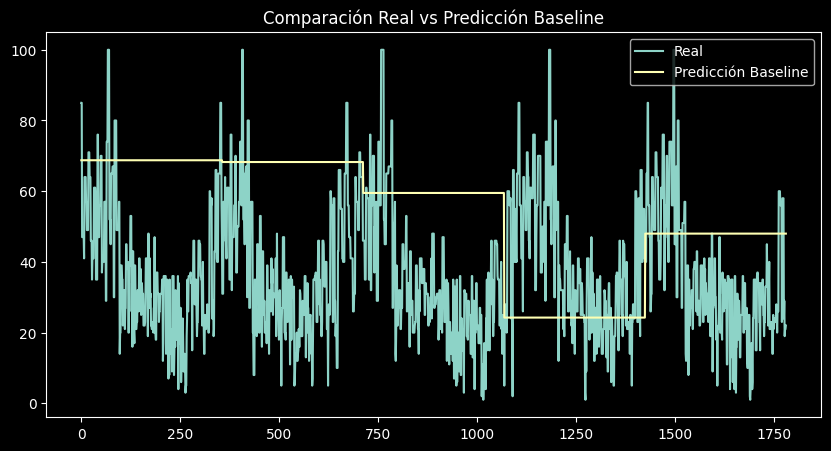

In [56]:
# Baseline: Media móvil simple (4 semanas)
resultados_baseline = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Predicción usando media móvil simple
    y_pred_baseline = y_train.rolling(window=4, min_periods=1).mean().iloc[-1]
    y_pred_baseline = np.full(shape=y_test.shape, fill_value=y_pred_baseline)

    # Evaluación
    rmse_baseline = np.sqrt(mean_squared_error(y_test, y_pred_baseline))

    resultados_baseline.append({
        'Real': y_test.values,
        'Predicción': y_pred_baseline,
        'RMSE': rmse_baseline
    })

resultados_baseline_df = pd.DataFrame(resultados_baseline)
print("RMSE Baseline (Media Móvil Simple): \n", resultados_baseline_df['RMSE'])

plt.figure(figsize=(10, 5))
plt.plot(resultados_baseline_df['Real'].explode().values, label='Real')
plt.plot(resultados_baseline_df['Predicción'].explode().values, label='Predicción Baseline')
plt.legend()
plt.title('Comparación Real vs Predicción Baseline')
plt.show()

### Modelo de Regresión Lineal

               Model       RMSE        R2
0  Linear Regression  17.053281  0.156961
1  Linear Regression  17.411043  0.133972
2  Linear Regression  17.825950  0.061849
3  Linear Regression  16.670233  0.253828
4  Linear Regression  15.880603  0.217750


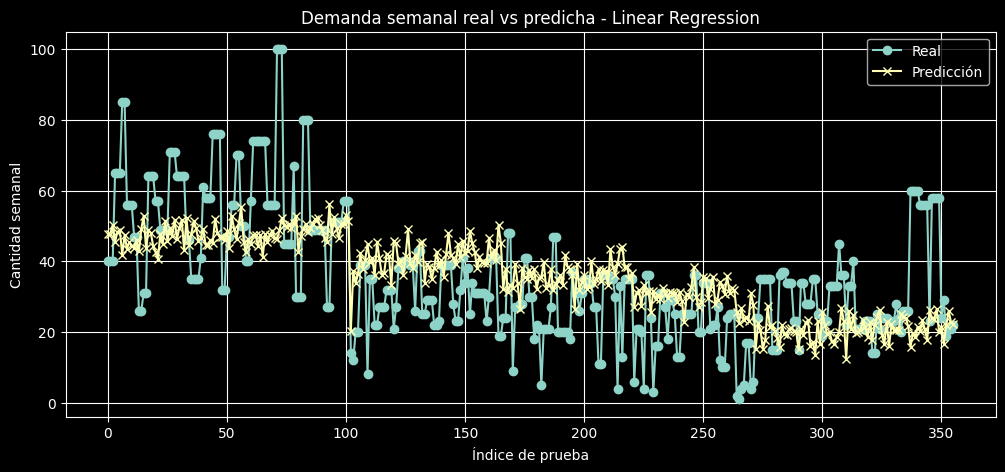

In [57]:
# Modelo de Regresión Lineal
results = []

X = X.ffill()

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Entrenamiento del modelo
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)

    # Predicciones
    y_pred_lr = lr_model.predict(X_test)

    # Evaluacion
    rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

    # Guardar resultados
    results.append({'Model': 'Linear Regression', 'RMSE': rmse_lr, 'R2': lr_model.score(X_test, y_test)})

# Display results
results_df = pd.DataFrame(results)
print(results_df)

# Predicciones vs Reales
plt.figure(figsize=(12, 5))
plt.plot(y_test.reset_index(drop=True), marker='o', label='Real')
plt.plot(pd.Series(y_pred_lr, name='Predicción'), marker='x', label='Predicción')
plt.title('Demanda semanal real vs predicha - Linear Regression')
plt.xlabel('Índice de prueba')
plt.ylabel('Cantidad semanal')
plt.legend()
plt.grid(True)
plt.show()

### LGBM

In [58]:

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    

    # LightGBM dataset
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

    # LightGBM parameters
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'verbose': -1
    }

    # Train the model
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=100,
                    valid_sets=lgb_eval
                    )
    
    # Predict
    y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f'RMSE: {rmse}')

RMSE: 13.468264997584862
RMSE: 12.603994767241309
RMSE: 9.507203630338545
RMSE: 8.954660905137377
RMSE: 8.269637807220692


Observamos que LGBM es el modelo con menor RMSE, lo que indica que es el más preciso para predecir la demanda semanal en este conjunto de datos. A continuación, presentamos las predicciones del modelo LGBM comparadas con los valores reales de demanda semanal por región.

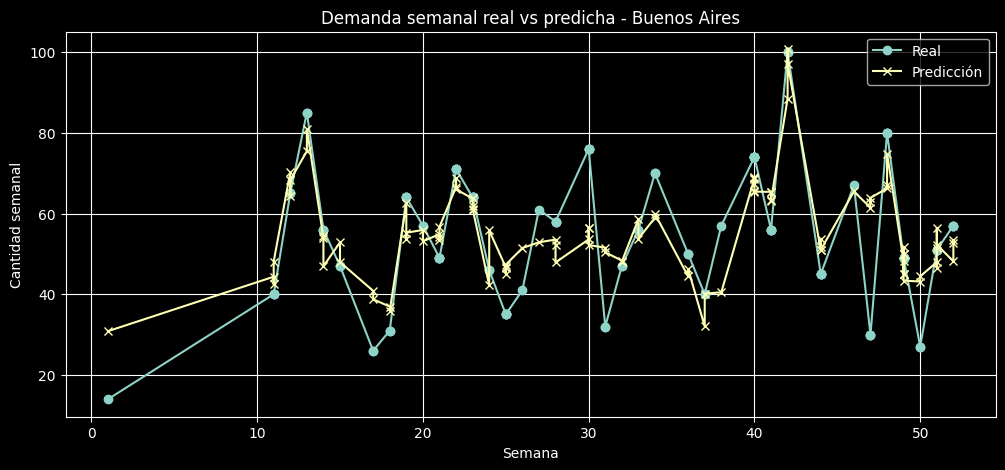

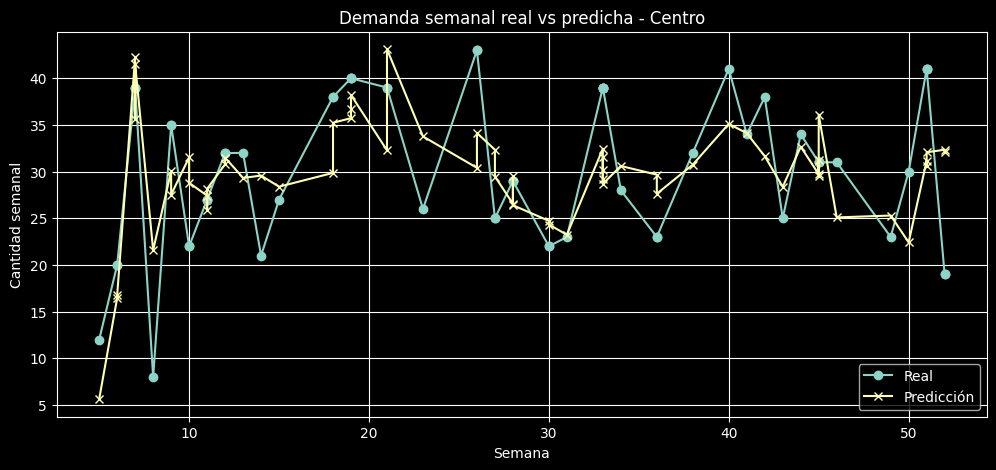

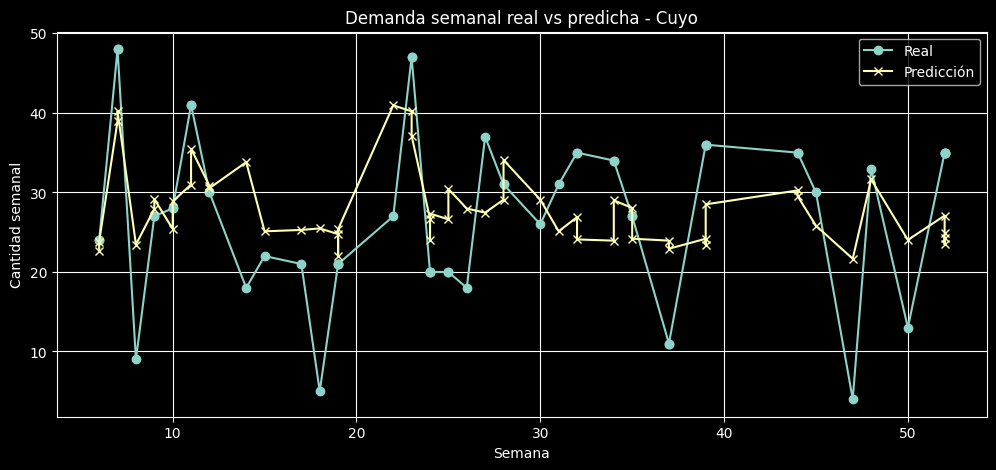

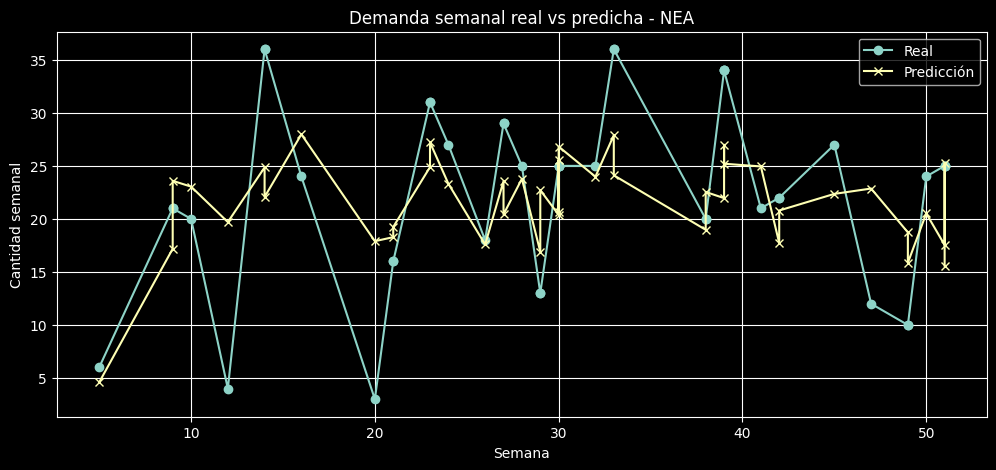

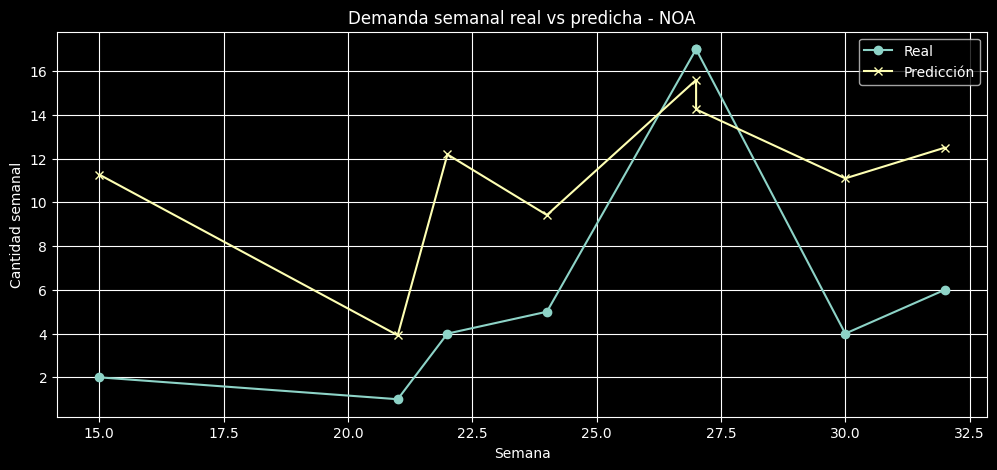

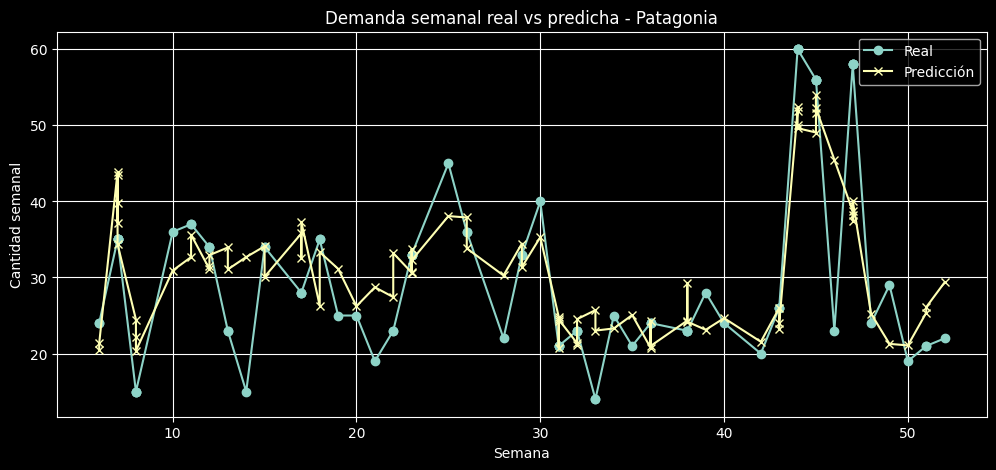

In [59]:
# Visualización de resultados por semana prediccion vs real por región
y_test_plot = y_test.reset_index(drop=True)
y_pred_plot = pd.Series(y_pred, name='Predicción')

# Crear un DataFrame para comparar real vs predicción
resultados = pd.DataFrame({
    'Semana': df_numeric.iloc[test_index]['semana'].reset_index(drop=True),
    'Region': df.iloc[test_index]['Region'].reset_index(drop=True),
    'Real': y_test_plot,
    'Predicción': y_pred_plot
})

# Graficar por región
for region in resultados['Region'].unique():
    datos_region = resultados[resultados['Region'] == region]
    datos_region = datos_region.sort_values(by='Semana')
    plt.figure(figsize=(12, 5))
    plt.plot(datos_region['Semana'], datos_region['Real'], marker='o', label='Real')
    plt.plot(datos_region['Semana'], datos_region['Predicción'], marker='x', label='Predicción')
    plt.title(f'Demanda semanal real vs predicha - {region}')
    plt.xlabel('Semana')
    plt.ylabel('Cantidad semanal')
    plt.legend()
    plt.grid(True)
    plt.show()